pip install langgraph


In [3]:
import os
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.schema import HumanMessage, SystemMessage




In [ ]:
openai_apikey='sk-proj-xxxxx'
openai_embedding_model = "text-embedding-ada-002"

In [5]:
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0, api_key=openai_apikey)
embeddings=OpenAIEmbeddings(model="text-embedding-ada-002", api_key=openai_apikey)

In [6]:
systemmessage = SystemMessage(content="you are an intelligent AI assitant, assigned wiht task with identifying categories, extracting key information from the given text")

## AGENT MEMORY

class CustState(TypedDict): 
    text: str 
    classification: str
    entities: List[str]
    summary: str

In [7]:
## classification

def classification_node(state: CustState):
    """"
    classify the text into one of predefined categories
    Parametrs:
       state(CustState): the current state dictionary containing the text to classify

    Return:
       dict: A dictionary wtih the "classification" key containing the category result
    categories:
       - News: Factual reporting of current events
       - Blog: Personal or informal web writing
       - Research:  Academic or scientific content
       - Other: Content that does not fit the above categories
    """

    prompt = PromptTemplate(
        input_variables=["text"],
        template="Classify the following text into one of the categories: News, Blog, Research, Technology or Other.If you know which category the text belongs, answer Other. do not provide additional details. \n\n Text: {text} \n\n Category:"
    )
    humanmessage = HumanMessage(content=prompt.format(text=state['text']))

    final_message = [
        systemmessage,
        humanmessage
        ]

    classification = llm.invoke(final_message).content.strip()
    return {'classification': classification}




In [13]:
## entities extraction
def entity_extraction_node(state: CustState):
    """
    Function to identify and extract named entities from text
    Organized by category (Person, Organization, Location)

    """
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Extract all entities(Person, Organization, Location) from the following text. Provide the answer as sequence of entites as key value pairs . \n\n Text: {text} \n\n Entities:"
    )

    humanmessage = HumanMessage(content=prompt.format(text=state['text']))
    final_message=[systemmessage,humanmessage]

    ## split the sequence into list python object of entities
    entities=llm.invoke(final_message).content.strip()
    print("entity extraction output:", entities)
    #entities = entities.split("\n")

    return {"entities": entities}


In [9]:
## Summarization 

def summarization_node(state: CustState):
    """
    instructing the model to summarize the input text in one sentence
    """
    summarization_prompt = PromptTemplate.from_template(
        """ 
        Summarize the following given text in one short sentence. Give the concise summary, no irrlevant deatils.\n\n Text: {input_text} \n\n Summary: 
        """
    )

    humanmessage = HumanMessage(content=summarization_prompt.format(input_text=state['text']))
    final_message = [systemmessage, humanmessage]
    ## Creating chain connecting the prompt template to llm
    #llm_chain = summarization_prompt | llm
    #response = llm_chain.invoke({"input_text": state["text"]})
    response = llm.invoke(final_message)
    return {"summary": response.content}



In [14]:
## defining the agent structure

workflow = StateGraph(CustState)

## adding nodes to the graph
workflow.add_node("classification_node", classification_node)
workflow.add_node("entity_extraction_node",entity_extraction_node)
workflow.add_node("summarization_node", summarization_node)

workflow.set_entry_point("classification_node")  ## entypoint
workflow.add_edge("classification_node","entity_extraction_node")
workflow.add_edge("entity_extraction_node", "summarization_node")
workflow.add_edge("summarization_node", END)

## copile the graph
app = workflow.compile()

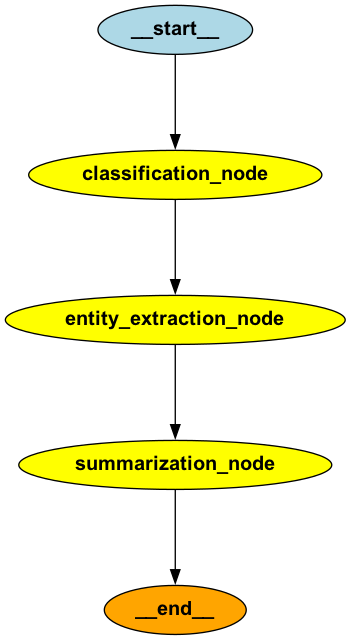

In [11]:
from IPython.display import Image

Image(app.get_graph().draw_png())

In [18]:
## testing the agent 

# Define a sample text about Anthropic's MCP to test our agent

sample_text="""Apple Inc. is an American multinational technology company that revolutionized the technology " \
"sector through its innovation of computer software, personal computers, mobile tablets, smartphones, and computer peripherals."""

# creating intial state with our sample text
state_input = {"text": sample_text}

## run the full workflow 
result = app.invoke(state_input)
print(type(result))

print("classification:", result['classification'])
print("entities:", result["entities"])
print("summary:", result['summary'])

entity extraction output: {
  "Person": [],
  "Organization": ["Apple Inc."],
  "Location": ["American"]
}
<class 'langgraph.pregel.io.AddableValuesDict'>
classification: Technology
entities: {
  "Person": [],
  "Organization": ["Apple Inc."],
  "Location": ["American"]
}
summary: Apple Inc. is an American multinational technology company known for revolutionizing the technology sector with its innovative products.
